In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

DATA_ROOT = 'data/haikou_25_30s'
path = os.path.join(DATA_ROOT, 'LHWMJ84D0H1170014_Qiong_A57528_20180321214435842.csv')

In [2]:
def load_voltage(path):
    # load data
    df = pd.read_csv(path, encoding='utf-8')
    voltage_df = pd.DataFrame({'Unit1': df['单体1电压'],
                               'Unit2': df['单体2电压'],
                               'BoundUpper': df['单体最高电压'],
                               'BoundLower': df['单体最低电压'],
                               'Time': df['数据时间']})
    # fill na with median
    for col in voltage_df.columns:
        if col in ['Time']:
            continue
        val_filled = voltage_df[col].median(axis=0)
        #print(col, voltage_df[col].median(axis=0))
        voltage_df[col].fillna(val_filled, inplace=True)

    return voltage_df

In [3]:
voltage_df = load_voltage(path)

   BoundLower  BoundUpper                 Time  Unit1  Unit2
0        3.31        3.32  2018-02-28 22:55:46   3.32   3.32
1        3.31        3.32  2018-02-28 22:55:16   3.32   3.32
2        3.32        3.32  2018-02-28 22:54:46   3.32   3.32
3        3.32        3.32  2018-02-28 22:54:14   3.32   3.32
4        3.32        3.32  2018-02-28 22:53:44   3.32   3.32
(48661, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48661 entries, 0 to 48660
Data columns (total 5 columns):
BoundLower    48661 non-null float64
BoundUpper    48661 non-null float64
Time          48661 non-null object
Unit1         48661 non-null float64
Unit2         48661 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None


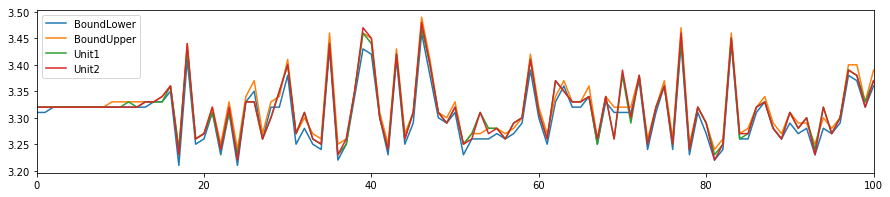

In [4]:
print(voltage_df.head())
print(voltage_df.shape)
print(voltage_df.info())
voltage_df.loc[:100,:].plot(figsize=(15, 3))

## ARIMA Model

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARMA

In [7]:
def is_stable(ts):
    adf = ADF(ts)
    return adf[1] < 0.05

def is_white_noise(values, lags):
    assert lags < len(values), 'lags should be less than length of values.'

    lbs, px = acorr_ljungbox(values, lags=lags) # p-value < 0.05 indicate there is white noise.
    h = np.sum(px  < 0.05)
    if h > 0: # at least one accept, it is not white noise.
        return False
    else:
        return True

def select_arma_params(ts, mode='aic', pmax=None, qmax=None):
    # mode can be 'bic', 'hq'
    # (p,q) always less than length / 10
    if pmax is None:
        pmax = len(ts) // 10
    if qmax is None:
        qmax = len(ts) // 10
    params = np.zeros([pmax, qmax])
    for p in range(pmax):
        for q in range(qmax):
            try:
                if mode == 'aic':
                    score = ARMA(ts, (p, q)).fit(disp=-1).aic
                elif mode == 'bic':
                    score = ARMA(ts, (p, q)).fit(disp=-1).bic
                elif mode == 'hq':
                    score = ARMA(ts, (p, q)).fit(disp=-1).hq
                else:
                    raise ValueError('The parameter mode is wrong!')
            except:
                score = None
            params[p, q] = score
    return params

def select_arma(ts, params, lags=12):
    while True:
        if np.argmin(params) == np.nan:
            break
        p, q = np.unravel_index(np.argmin(params, axis=None), params.shape)
        print('check index = [{}, {}], and value = {}'.format(p, q, params[p, q]))
        arma = ARMA(ts, (p, q)).fit(disp=-1)
        pred = arma.predict()
        res = (pred - ts).dropna()
        if is_white_noise(res, lags=lags):
            return (p, q)
        else:
            params[p, q] = np.nan
            continue
    return (np.nan, np.nan)

In [8]:
n_train = 2000
y = voltage_df['BoundUpper'][:n_train]
print('is stable = {}'.format(is_stable(y)))
print('is white noise = {}'.format(is_white_noise(y, 1)))

is stable = True
is white noise = False


In [9]:
params = select_arma_params(y, 'aic', pmax=10, qmax=10)

/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
p, q = select_arma(y, params)

check index = [1, 4], and value = nan


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

### ARMA model

In [188]:
ts = voltage_df['Unit1']
id_train = 100
id_test = 200

In [206]:
arma_voltage = sm.tsa.ARMA(ts[:id_train], (3,0)).fit(disp=False)

In [16]:
n_train = 1000
y = voltage_df['BoundUpper'][:n_train]
print(arima_voltage.params)

NameError: name 'arima_voltage' is not defined

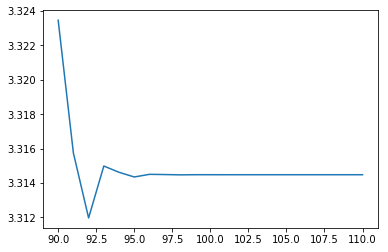

In [208]:
predict_sunspots = arma_voltage.predict(90, 110, dynamic=True)
plt.plot(predict_sunspots)

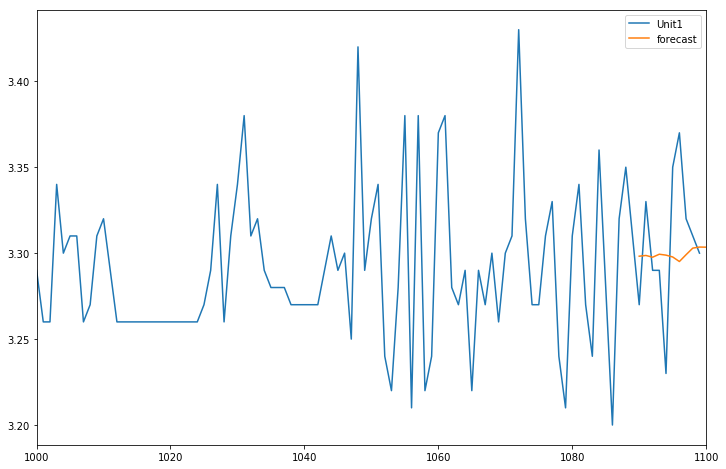

In [289]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = ts[:id_train].plot(ax=ax)
fig = arma_voltage.plot_predict(90, 100, dynamic=False, ax=ax, plot_insample=False)

In [362]:
from statsmodels.stats.diagnostic import acorr_ljungbox
p_value =  acorr_ljungbox(ts, lags=1)[1]
p_value

array([  8.89617373e-15])

In [9]:
pmax = 10 # 一般阶数不超过length/10
qmax = 10 # 一般阶数不超过length/10
 
matrix = [] # aic矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try:#存在部分为空值，会报错
#             tmp.append(ARMA(xdata2, (p,q)).fit().bic) #  BIC方式
            tmp.append(ARMA(y, (p,q)).fit().aic) #  AIC方式
#             tmp.append(ARMA(xdata2, (p,q)).fit().hq) #  HQ方式
        except:
            tmp.append(None)
            
    matrix.append(tmp)
    
matrix = pd.DataFrame(matrix) # 从中可以找出最小值
print(matrix)
print(matrix.stack())

/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


             0            1            2            3            4   \
0  -5928.968349 -5950.219898 -5981.862093 -6010.598980 -6009.466362   
1  -5956.636789 -6103.408433 -6101.494796 -6105.048948          NaN   
2  -5996.921067 -6101.504134 -6100.219014 -6098.258756          NaN   
3  -6027.805875 -6104.729418 -6098.266837 -6102.093171 -6109.148167   
4  -6026.933271 -6108.783847          NaN -6108.957946 -6107.168680   
5  -6037.731198 -6110.422696          NaN          NaN -6105.168684   
6  -6042.634551 -6108.899947 -6107.058139          NaN          NaN   
7  -6051.020396 -6106.899949 -6105.407154          NaN          NaN   
8  -6052.895211          NaN -6103.431397          NaN          NaN   
9  -6056.038030 -6103.650524          NaN          NaN          NaN   
10 -6061.966907          NaN          NaN          NaN          NaN   

             5            6            7           8           9            10  
0  -6018.978420 -6022.112520 -6026.716117 -6027.92736 -6030.44668 

In [10]:
matrix

0            1            2            3            4   \
0  -5928.968349 -5950.219898 -5981.862093 -6010.598980 -6009.466362   
1  -5956.636789 -6103.408433 -6101.494796 -6105.048948          NaN   
2  -5996.921067 -6101.504134 -6100.219014 -6098.258756          NaN   
3  -6027.805875 -6104.729418 -6098.266837 -6102.093171 -6109.148167   
4  -6026.933271 -6108.783847          NaN -6108.957946 -6107.168680   
5  -6037.731198 -6110.422696          NaN          NaN -6105.168684   
6  -6042.634551 -6108.899947 -6107.058139          NaN          NaN   
7  -6051.020396 -6106.899949 -6105.407154          NaN          NaN   
8  -6052.895211          NaN -6103.431397          NaN          NaN   
9  -6056.038030 -6103.650524          NaN          NaN          NaN   
10 -6061.966907          NaN          NaN          NaN          NaN   

             5            6            7           8           9            10  
0  -6018.978420 -6022.112520 -6026.716117 -6027.92736 -6030.44668 -6039.362426  
1           NaN          NaN          NaN         NaN         NaN          NaN  
2           NaN          NaN          NaN         NaN         NaN          NaN  
3           NaN          NaN -6106.796951         NaN         NaN          NaN  
4  -6106.998272          NaN          NaN         NaN         NaN          NaN  
5  -6106.466448 -6106.369175 -6108.717496         NaN         NaN          NaN  
6           NaN -6106.192620 -6102.024719         NaN         NaN          NaN  
7  -6105.719045 -6102.165214          NaN         NaN         NaN          NaN  
8           NaN          NaN          NaN         NaN         NaN          NaN  
9           NaN          NaN          NaN         NaN         NaN          NaN  
10          NaN          NaN          NaN         NaN         NaN          NaN

In [386]:
test = np.array([[1,2,3], [2, 0, 4]])

In [387]:
np.unravel_index(np.argmin(test, axis=None), test.shape)

(1, 1)

In [233]:
while 1:
    p, q = matrix.stack().idxmin() # 先展平该表格，然后找出最小值的索引位置
    print (u'当前AIC最小的p值与q值分别为：%s、%s' % (p,q))
    
    lagnum = 12 # 残差延迟个数
 
    arma = ARMA(ts, (p,q)).fit() # 建立并训练模型
    xdata_pred = arma.predict() # 预测
    pred_error = (xdata_pred - ts).dropna() # 计算残差
 
    # 白噪声检测
    from statsmodels.stats.diagnostic import acorr_ljungbox
 
    lbx, px = acorr_ljungbox(pred_error, lags = lagnum)
    h = (px < 0.05).sum() # p值小于0.05，认为是非噪声
    if h > 0:
        print (u'模型ARMA(%s,%s)不符合白噪声检验' % (p,q))
        print ('在AIC矩阵中去掉[%s,%s]组合，重新进行计算' % (p,q))
        matrix.iloc[p,q] =  np.nan
        arimafail = arma
        continue
    else:
        print (p,q)
        print (u'模型ARMA(%s,%s)符合白噪声检验' % (p,q))
        break

当前AIC最小的p值与q值分别为：2、1
模型ARMA(2,1)不符合白噪声检验
在AIC矩阵中去掉[2,1]组合，重新进行计算
当前AIC最小的p值与q值分别为：0、0
模型ARMA(0,0)不符合白噪声检验
在AIC矩阵中去掉[0,0]组合，重新进行计算
当前AIC最小的p值与q值分别为：0、1


/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


模型ARMA(0,1)不符合白噪声检验
在AIC矩阵中去掉[0,1]组合，重新进行计算
当前AIC最小的p值与q值分别为：1、0
模型ARMA(1,0)不符合白噪声检验
在AIC矩阵中去掉[1,0]组合，重新进行计算
当前AIC最小的p值与q值分别为：3、2
模型ARMA(3,2)不符合白噪声检验
在AIC矩阵中去掉[3,2]组合，重新进行计算
当前AIC最小的p值与q值分别为：2、3
模型ARMA(2,3)不符合白噪声检验
在AIC矩阵中去掉[2,3]组合，重新进行计算
当前AIC最小的p值与q值分别为：2、0
模型ARMA(2,0)不符合白噪声检验
在AIC矩阵中去掉[2,0]组合，重新进行计算
当前AIC最小的p值与q值分别为：0、2
模型ARMA(0,2)不符合白噪声检验
在AIC矩阵中去掉[0,2]组合，重新进行计算
当前AIC最小的p值与q值分别为：1、1
模型ARMA(1,1)不符合白噪声检验
在AIC矩阵中去掉[1,1]组合，重新进行计算
当前AIC最小的p值与q值分别为：0、3
模型ARMA(0,3)不符合白噪声检验
在AIC矩阵中去掉[0,3]组合，重新进行计算
当前AIC最小的p值与q值分别为：3、0
模型ARMA(3,0)不符合白噪声检验
在AIC矩阵中去掉[3,0]组合，重新进行计算
当前AIC最小的p值与q值分别为：5、2


/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 2
模型ARMA(5,2)符合白噪声检验


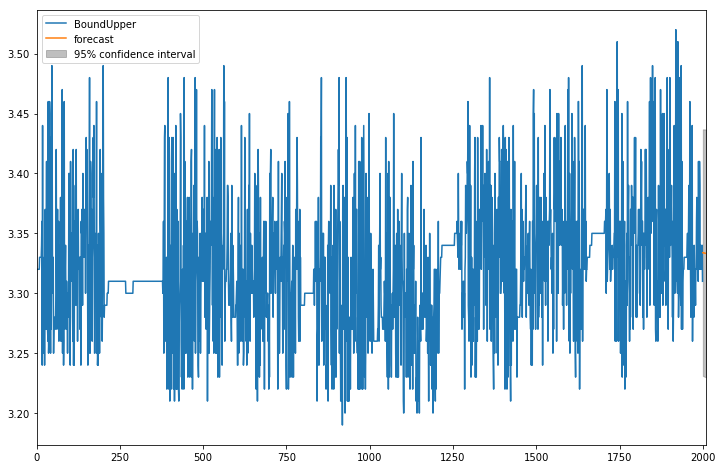

In [20]:
ts = voltage_df['BoundUpper']
#ts = (ts - np.mean(ts)) / np.std(ts)
id_train = 2000
id_test = 200
arma_uper = sm.tsa.ARMA(ts[:id_train], (3,2)).fit(disp=False)

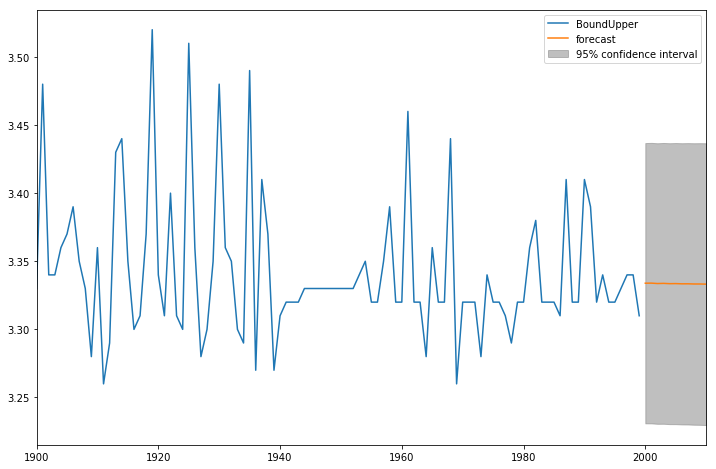

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = ts[1900:id_train].plot(ax=ax)
fig = arma_uper.plot_predict(2000, 2010, dynamic=False, ax=ax, plot_insample=False)

In [28]:
for t in range(20):
    model = ARIMA(y, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

NameError: name 'ARIMA' is not defined

/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


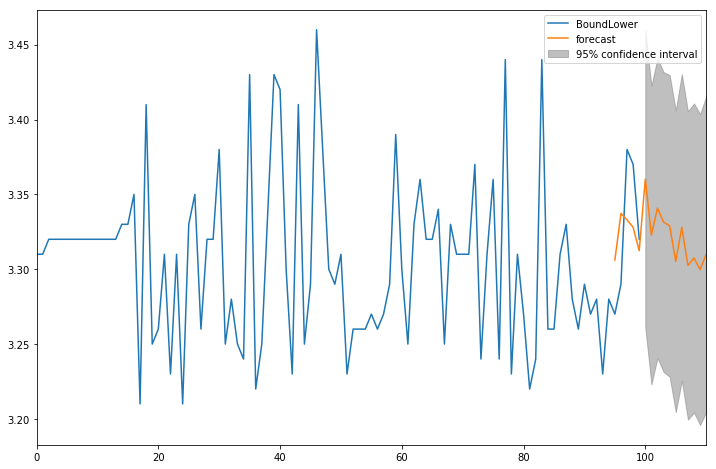

In [297]:
ts = voltage_df['BoundLower']
#ts = (ts - np.mean(ts)) / np.std(ts)
id_train = 100
id_test = 200
arma_lower = sm.tsa.ARMA(ts[:id_train], (10,4)).fit(disp=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax = ts[:id_train].plot(ax=ax)
fig = arma_lower.plot_predict(95, 110, dynamic=False, ax=ax, plot_insample=False)

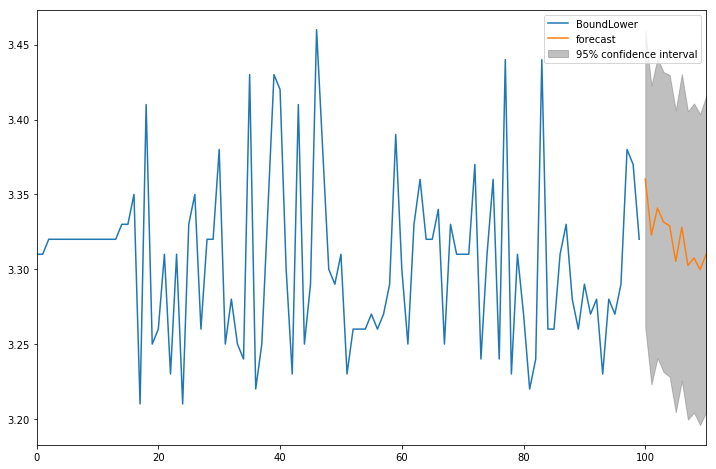

In [367]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = ts[:id_train].plot(ax=ax)
fig = arma_lower.plot_predict(100, 110, dynamic=False, ax=ax, plot_insample=False)

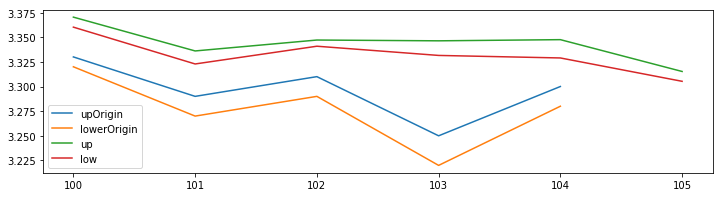

In [375]:
ts_hat_uper = arma_uper.predict(start=100, end=105, dynamic=True)
ts_hat_lower = arma_lower.predict(start=100, end=105, dynamic=True)
plt.figure(figsize=(12, 3))
plt.plot(voltage_df['BoundUper'][100:105], label='upOrigin')
plt.plot(voltage_df['BoundLower'][100:105], label='lowerOrigin')
plt.plot(ts_hat_uper, label='up')
plt.plot(ts_hat_lower, label='low')
plt.legend(loc='best')

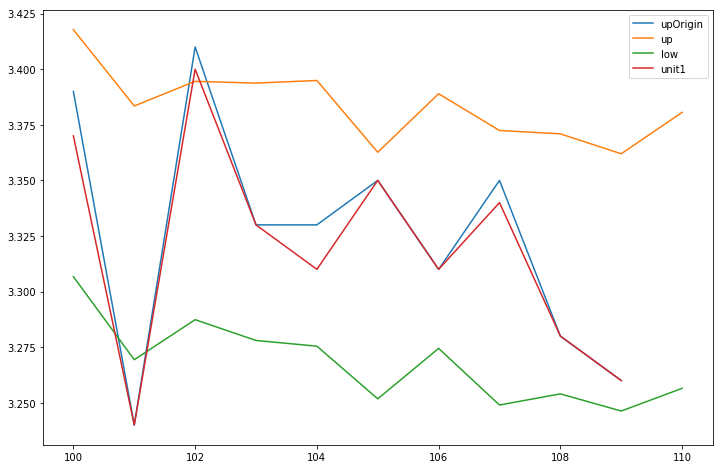

In [357]:
plt.figure(figsize=(12, 8))
plt.plot(voltage_df['BoundUper'][100:110], label='upOrigin')
plt.plot(ts_hat_uper+3*np.std(ts_hat_uper), label='up')
plt.plot(ts_hat_lower-3*np.std(ts_hat_lower), label='low')
plt.plot(voltage_df['Unit1'][100:110], label='unit1')
plt.legend(loc='best')

In [285]:
ts = voltage_df['Unit1'][1000:]
#ts = (ts - np.mean(ts)) / np.std(ts)
id_train = 100
id_test = 200
arma_voltage = sm.tsa.ARMA(ts, (3,2)).fit(disp=False)

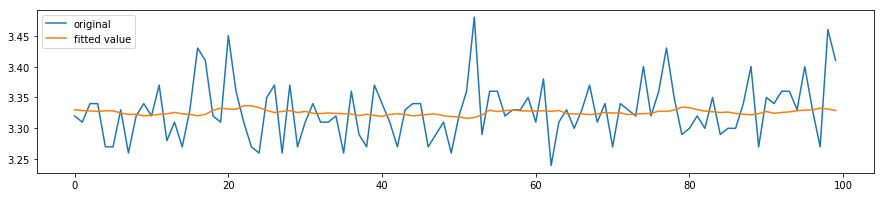

In [286]:
plt.figure(figsize=(15,3))
plt.plot(ts[1000:1100].values, label='original')
plt.plot(arma_voltage.fittedvalues[1000:1100].values, label='fitted value')
plt.legend(loc='best')

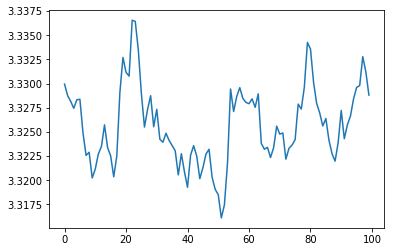

In [287]:
plt.plot(arma_voltage.fittedvalues[1000:1100].values, label='fitted value')

/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Program/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


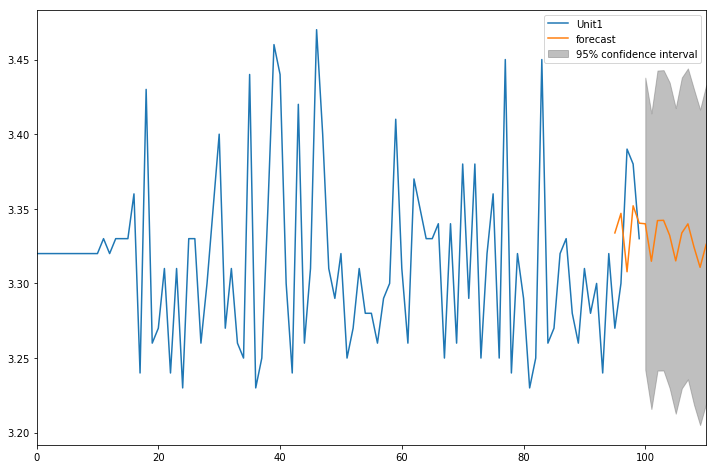

In [251]:
ts = voltage_df['Unit1']
#ts = (ts - np.mean(ts)) / np.std(ts)
id_train = 100
id_test = 200
arma_voltage = sm.tsa.ARMA(ts[:id_train], (10,5)).fit(disp=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax = ts[:id_train].plot(ax=ax)
fig = arma_voltage.plot_predict(95, 110, dynamic=True, ax=ax, plot_insample=False)

### Time series analysis

reference: https://blog.csdn.net/u012063773/article/details/79313645

In [224]:
ts = voltage_df['Unit1']
id_train = 100
id_test = 200

In [227]:
# verify the stability
from statsmodels.tsa.stattools import adfuller as ADF

adf = ADF(ts)
diff = 0
print(adf)

while adf[1] >= 0.05: # adf[1] is p-value, it is mean stable when p-value less than 0.05
    print(adf[1])
    diff += 1
    adf = ADF(ts.diff(diff).dropna())

print('diff original {} times can make it stable, and p-value is {}'.format(diff, adf[1]))

(-17.833746084766691, 3.125855113548533e-30, 56, 48604, {'1%': -3.4304845495308234, '5%': -2.8615994680917027, '10%': -2.5668016529049789}, -161748.52495512887)
diff original 0 times can make it stable, and p-value is 3.125855113548533e-30


In [231]:
# verify white noise
from statsmodels.stats.diagnostic import acorr_ljungbox

[[lb], [p]] = acorr_ljungbox(ts, lags=1)
if p < 0.05:
    print("the original ts isn't white noise, and p-value is {}".format(p))
else:
    print("the original ts is white noise, and p-value is {}".format(p))

the original ts isn't white noise, and p-value is 5.952171610231831e-34


In [ ]:
# model selection

In [316]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [320]:
fit2 = SimpleExpSmoothing(voltage_df.BoundLower[:id_train]).fit(smoothing_level=0.6,optimized=False)

In [321]:
fit2.forecast(10)

100    3.335305
101    3.335305
102    3.335305
103    3.335305
104    3.335305
105    3.335305
106    3.335305
107    3.335305
108    3.335305
109    3.335305
dtype: float64

In [322]:
voltage_df.BoundLower[id_train:(id_train+10)]

100    3.36
101    3.22
102    3.39
103    3.32
104    3.31
105    3.35
106    3.30
107    3.34
108    3.26
109    3.25
Name: BoundLower, dtype: float64

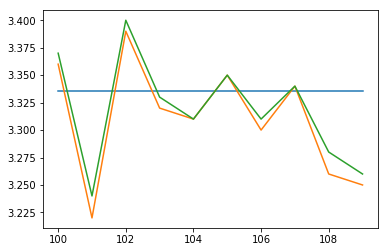

In [325]:
plt.plot(fit2.forecast(10))
plt.plot(voltage_df.BoundLower[id_train:(id_train+10)])
plt.plot(voltage_df.Unit1[id_train:(id_train+10)])

### ARMA 
a tutorial from official website: https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html

In [156]:
import statsmodels.api as sm

In [157]:
dta = sm.datasets.sunspots.load_pandas().data

In [162]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

In [170]:
dta

SUNACTIVITY
1700-12-31          5.0
1701-12-31         11.0
1702-12-31         16.0
1703-12-31         23.0
1704-12-31         36.0
1705-12-31         58.0
1706-12-31         29.0
1707-12-31         20.0
1708-12-31         10.0
1709-12-31          8.0
1710-12-31          3.0
1711-12-31          0.0
1712-12-31          0.0
1713-12-31          2.0
1714-12-31         11.0
1715-12-31         27.0
1716-12-31         47.0
1717-12-31         63.0
1718-12-31         60.0
1719-12-31         39.0
1720-12-31         28.0
1721-12-31         26.0
1722-12-31         22.0
1723-12-31         11.0
1724-12-31         21.0
1725-12-31         40.0
1726-12-31         78.0
1727-12-31        122.0
1728-12-31        103.0
1729-12-31         73.0
...                 ...
1979-12-31        155.4
1980-12-31        154.6
1981-12-31        140.4
1982-12-31        115.9
1983-12-31         66.6
1984-12-31         45.9
1985-12-31         17.9
1986-12-31         13.4
1987-12-31         29.4
1988-12-31        100.2
1989-12-31        157.6
1990-12-31        142.6
1991-12-31        145.7
1992-12-31         94.3
1993-12-31         54.6
1994-12-31         29.9
1995-12-31         17.5
1996-12-31          8.6
1997-12-31         21.5
1998-12-31         64.3
1999-12-31         93.3
2000-12-31        119.6
2001-12-31        111.0
2002-12-31        104.0
2003-12-31         63.7
2004-12-31         40.4
2005-12-31         29.8
2006-12-31         15.2
2007-12-31          7.5
2008-12-31          2.9

[309 rows x 1 columns]

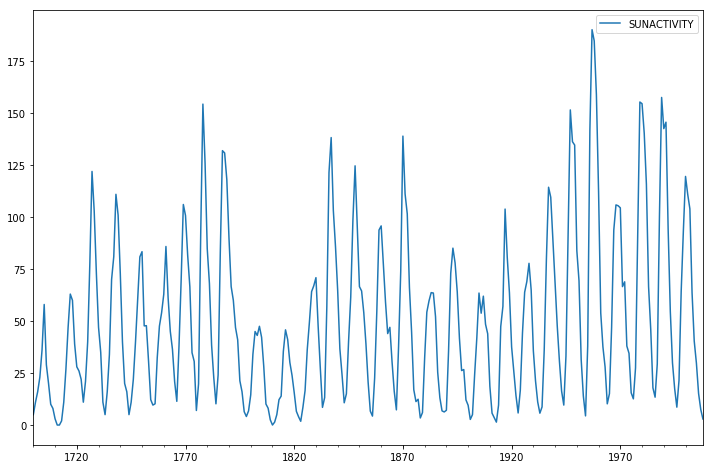

In [164]:
dta.plot(figsize=(12,8));

In [165]:
arma_mod30 = sm.tsa.ARMA(dta, (3,0)).fit(disp=False)

/Program/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


In [166]:
print(arma_mod30.params)

const                49.749936
ar.L1.SUNACTIVITY     1.300810
ar.L2.SUNACTIVITY    -0.508093
ar.L3.SUNACTIVITY    -0.129650
dtype: float64


In [167]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

2619.4036286964474 2638.07033508 2626.8666135


In [168]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9564807635787604

In [169]:
predict_sunspots = arma_mod30.predict('1990', '2012', dynamic=True)
print(predict_sunspots)

1990-12-31    167.047417
1991-12-31    140.993002
1992-12-31     94.859112
1993-12-31     46.860896
1994-12-31     11.242577
1995-12-31     -4.721303
1996-12-31     -1.166920
1997-12-31     16.185687
1998-12-31     39.021884
1999-12-31     59.449878
2000-12-31     72.170152
2001-12-31     75.376793
2002-12-31     70.436464
2003-12-31     60.731586
2004-12-31     50.201791
2005-12-31     42.076018
2006-12-31     38.114277
2007-12-31     38.454635
2008-12-31     41.963810
2009-12-31     46.869285
2010-12-31     51.423261
2011-12-31     54.399720
2012-12-31     55.321692
Freq: A-DEC, dtype: float64


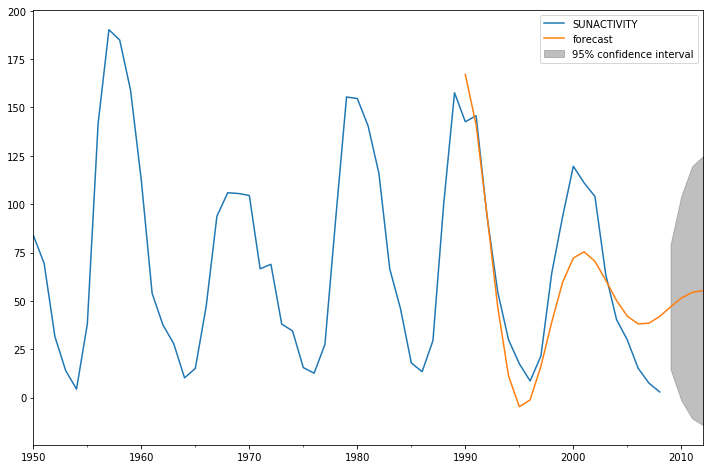

In [183]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.loc['1950':].plot(ax=ax)
fig = arma_mod30.plot_predict('1990', '2012', dynamic=True, ax=ax, plot_insample=False)